In [5]:
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn
import os
import numpy as np

In [6]:
list_name = ['rgerg', 'faesgfaer']
df = pd.DataFrame(
    {
        # "B": [1, 1, 1, 1, 1, 1, 1, 1],
        "C": np.random.randn(8),
        "D": np.random.randn(8),
    }
)

def func_test(row, list_name):
    # list_name = ['rgerg', 'faesgfaer']
    a = row['C']
    str1 = ''
    for n in list_name:
        str1 = str1 + n + str(a)

    return str1

df['E'] = df.apply(func_test, axis=1, args=(list_name))
print(df)

TypeError: func_test() takes 2 positional arguments but 3 were given

In [7]:
# functions for reading data

def read_data_qc2dstag_decomposition(path, params, sigma):
    data = []
    for key, value in params.items():
        data.append(pd.read_csv(f"{path}/potential_{key}.csv", index_col=None))
        data[-1] = data[-1][data[-1]['T'] == value]
        data[-1] = data[-1].drop(['T'], axis = 1)
        data[-1].reset_index(drop=True, inplace=True)
        data[-1] = data[-1].rename(columns={'aV(r)': f'aV(r)_{key}', 'err': f'err_{key}'})
        data[-1]['r/a'] = data[-1]['r/a'] * math.sqrt(sigma)
        data[-1][f'aV(r)_{key}'] = data[-1][f'aV(r)_{key}'] / math.sqrt(sigma)
        data[-1][f'err_{key}'] = data[-1][f'err_{key}'] / math.sqrt(sigma)
    data = pd.concat(data, axis = 1)
    data = data.loc[:,~data.columns.duplicated()]

    return data

def read_data_qc2dstag_decomposition_smearing(paths, sigma):
    data = []
    for key, value in paths.items():
        data.append(pd.read_csv(value[0], index_col=None))
        data[-1] = data[-1][data[-1]['smearing_step'] == value[1]]
        data[-1] = data[-1][data[-1]['T'] == value[2]]
        data[-1] = data[-1].drop(['T'], axis = 1)
        data[-1].reset_index(drop=True, inplace=True)
        data[-1] = data[-1].rename(columns={'aV(r)': f'aV(r)_{key}', 'err': f'err_{key}'})
        data[-1]['r/a'] = data[-1]['r/a'] * math.sqrt(sigma)
        data[-1][f'aV(r)_{key}'] = data[-1][f'aV(r)_{key}'] / math.sqrt(sigma)
        data[-1][f'err_{key}'] = data[-1][f'err_{key}'] / math.sqrt(sigma)
    data = pd.concat(data, axis = 1)
    data = data.loc[:,~data.columns.duplicated()]

    return data

def read_file_vitaliy(file_path, T_max):
    if(os.path.isfile(file_path)):
        df = []
        with open(file_path, 'r') as f:
            lines = f.readlines()

            R_sizes = []
            T_sizes = list(range(1, T_max + 1))
            for line in lines:
                line_split = line.split()
                R_sizes = [int(line_split[0])] * T_max
                line_potential = []
                line_err = []
                for i in range(3):
                    line_potential.append([float(i) for i in line_split[1 + i * (2 * T_max + 1) : T_max + 1 + i * (2 * T_max + 1)]])
                    line_err.append([float(i) for i in line_split[T_max + 1 + i * (2 * T_max + 1) : 2 * T_max + 1 + i * (2 * T_max + 1)]])

                df.append(pd.DataFrame({'R': R_sizes, 'T': T_sizes, 'potential_monopole': line_potential[0], 'err_monopole': line_err[0],
                'potential_monopoless': line_potential[1], 'err_monopoless': line_err[1],
                'potential_su2': line_potential[2], 'err_su2': line_err[2]}))

            return pd.concat(df)

def read_data_potential_vitaliy():
    data = []
    data.append(read_file_vitaliy('../result/potential/on-axis/su2/vitaliy/pot_vs_r_all3_B2p4.dat', 11))
    data[-1]['beta'] = float(2.4)
    data[-1]['sigma'] = float(0.258265528440037)
    data.append(read_file_vitaliy('../result/potential/on-axis/su2/vitaliy/pot_vs_r_all3_B2p5.dat', 11))
    data[-1]['beta'] = float(2.5)
    data[-1]['sigma'] = float(0.181839887534859)
    data.append(read_file_vitaliy('../result/potential/on-axis/su2/vitaliy/pot_vs_r_all3_b2p6_L32.dat', 15))
    data[-1]['beta'] = float(2.6)
    data[-1]['sigma'] = float(0.134725276024954)

    return pd.concat(data)

In [8]:
def save_image(image_path, image_name, fg):
    try:
        os.makedirs(image_path)
    except:
        pass
    
    output_path = f'{image_path}/{image_name}'
    print(output_path)
    fg.savefig(output_path, dpi=400)

def plot_relative_variation_potential(data):
    # T = data['T'].iloc[0]
    # sigma = data['sigma'].iloc[0]
    fg = seaborn.FacetGrid(data=data, hue = 'beta', height=5, aspect=1.2)
    fg.fig.suptitle(f'relative variation')
    fg.map(plt.errorbar, 'R', 'potential_diff', 'err_diff', marker="o", fmt='', linestyle = ''
    ).add_legend()
    fg.ax.set_xlabel(r"r$\sqrt{\sigma}$")
    fg.ax.set_ylabel(r"$\Delta$")
    plt.xlim((0, 2.5))
    plt.ylim((-0.3, 0.3))
    fg.ax.spines['right'].set_visible(True)
    fg.ax.spines['top'].set_visible(True)
    fg.ax.minorticks_on()
    fg.ax.tick_params(which = 'both', bottom = True, top = True, left = True, right = True)
    plt.axhline(y = 0, color = 'k', linestyle = '-')
    # plt.show()

    save_image(f'../images/potential/relative_variation/vitaliy', f'relative_variation', fg)

def choose_data(data, T_sizes):
    data_new = []
    for beta in [2.4, 2.5, 2.6]:
        df = []
        df1 = data[data['beta'] == beta]
        for monopole in ['monopole', 'monopoless', 'su2']:
            df.append(df1[df1['T'] == T_sizes[beta][monopole]][['R', f'potential_{monopole}', f'err_{monopole}', 'beta', 'sigma']])

        df[-1] = df[-1].reset_index()
        df[-2] = df[-2].reset_index()
        df[-3] = df[-3].reset_index()

        df = pd.concat(df, axis = 1).reset_index()
        df = df.loc[:,~df.columns.duplicated()]
        data_new.append(df)

    return pd.concat(data_new)
        
def relative_variation_potential():
    data = read_data_potential_vitaliy()

    T_sizes = {2.4: {'monopole': 5, 'monopoless': 6, 'su2': 8}, 
        2.5: {'monopole': 5, 'monopoless': 6, 'su2': 8}, 
        2.6: {'monopole': 7, 'monopoless': 6, 'su2': 9}}
    data = choose_data(data, T_sizes)

    data = data[data['potential_su2'] != 0.0]

    data['potential_diff'] = data.apply(lambda x: x['potential_su2'] - x['potential_monopole'] - x['potential_monopoless'], axis=1)
    data['err_diff'] = data.apply(lambda x: math.sqrt(x['err_su2'] ** 2 + x['err_monopole'] ** 2 + x['err_monopoless'] ** 2), axis=1)
    data['err_diff'] = data.apply(lambda x: math.sqrt(x['err_diff'] ** 2 / x['potential_su2'] ** 2 + x['err_su2'] ** 2 * x['potential_diff'] ** 2 / x['potential_su2'] ** 4), axis=1)
    data['potential_diff'] = data.apply(lambda x: x['potential_diff'] / x['potential_su2'], axis=1)

    data['R'] = data.apply(lambda x: x['R'] * x['sigma'], axis = 1)

    plot_relative_variation_potential(data)


def plot_potential_decomposition(data, image_path, image_name):
    fg = seaborn.FacetGrid(data=data, hue = 'matrix_type', height=5, aspect=1.4, legend_out=False, hue_kws={"ls" : ['-', '--', '--', '']})
    fg.fig.suptitle(f'potential decomposition')
    fg.map(plt.errorbar, 'r/a', 'aV(r)', 'err', mfc=None, fmt='o', ms = 3, capsize = 5, lw = 0.5
    ).add_legend()
    # plt.legend(loc='upper left')
    fg.ax.set_xlabel(r"R$\sqrt{\sigma}$")
    fg.ax.set_ylabel(r"V(r)/$\sigma$")
    fg.ax.spines['right'].set_visible(True)
    fg.ax.spines['top'].set_visible(True)
    fg.ax.minorticks_on()
    fg.ax.tick_params(which = 'both', bottom = True, top = True, left = True, right = True)
    plt.grid(dash_capstyle = 'round')

    plt.show()
    save_image(image_path, image_name, fg)

def join_back(data, matrix_types):
    data1 = []
    for matrix_type in matrix_types:
        data1.append(data[['r/a', f'aV(r)_{matrix_type}', f'err_{matrix_type}']])
        data1[-1] = data1[-1].rename(columns={f'aV(r)_{matrix_type}': 'aV(r)', f'err_{matrix_type}': 'err'})
        if matrix_type == 'monopole':
            matrix_type1 = 'mon'
        elif matrix_type == 'monopoless':
            matrix_type1 = 'mod'
        elif matrix_type == 'mon+nomon':
            matrix_type1 = 'mon+mod'
        else:
            matrix_type1 = matrix_type
        data1[-1]['matrix_type'] = matrix_type1

    return pd.concat(data1)

def find_sum(data, term1, term2, sum):
    data[f'err_' + sum] = data.apply(lambda x: math.sqrt(x[f'err_' + term1] ** 2 + x[f'err_' + term2] ** 2), axis = 1)
    data[f'aV(r)_' + sum] = data.apply(lambda x: x[f'aV(r)_' + term1] + x[f'aV(r)_' + term2], axis = 1)

    return data

def potential_decomposition(paths, image_path, image_name, sigma):
    data = read_data_qc2dstag_decomposition_smearing(paths, sigma)

    data = find_sum(data, 'monopole', 'monopoless', 'mon+nomon')

    data = join_back(data, ['su2', 'monopole', 'monopoless', 'mon+nomon'])

    plot_potential_decomposition(data, image_path, image_name)

def potential_decomposition_phot(path, params, image_path, image_name, sigma):
    data = read_data_qc2dstag_decomposition(path, params, sigma)

    data = find_sum(data, 'photon', 'monopole', 'mon+phot')

    data = join_back(data, ['abelian', 'monopole', 'photon', 'mon+phot'])

    plot_potential_decomposition(data, image_path, image_name)

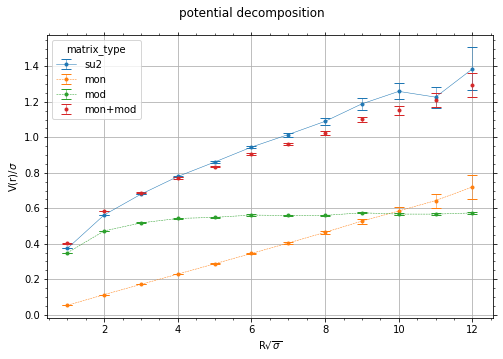

../images/potential/decomposition/qc2dstag/potential_qc2dstag_mu00


In [11]:
path = '../../result/smearing/potential/su2/su2_suzuki/24^4/beta2.4'
paths = {'su2': (f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/potential_original.csv', 100, 4), 
        'monopole': (f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/T_step=0.0001/T_final=0.0001/OR_steps=6/potential_monopole.csv', 80, 6), 
        'monopoless': (f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/T_step=0.0001/T_final=0.0001/OR_steps=6/potential_monopoless.csv', 80, 6)}
potential_decomposition(paths, f'../images/potential/decomposition/qc2dstag', 'potential_qc2dstag_mu00', 1)

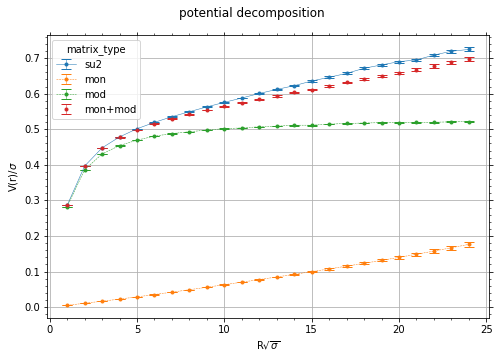

../images/potential/decomposition/su2_suzuki/potential_su2_suzuki_beta2p7


In [10]:
path = '../../result/smearing/potential/su2/su2_suzuki/48^4/beta2.7'
paths = {'su2': (f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/potential_original.csv', 400, 6), 
        'monopole': (f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/T_step=0.0005/T_final=0.5/OR_steps=4/potential_monopole.csv', 400, 16), 
        'monopoless': (f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/T_step=0.0005/T_final=0.5/OR_steps=4/potential_monopoless.csv', 400, 6)}
potential_decomposition(paths, f'../images/potential/decomposition/su2_suzuki', 'potential_su2_suzuki_beta2p7', 1)

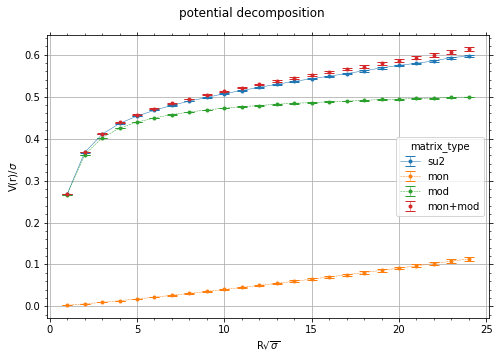

../../images/potential/decomposition/su2_suzuki/potential_su2_suzuki_beta2p8_0p001


In [17]:
path = '../../result/smearing/potential/su2/su2_suzuki/48^4/beta2.8'
paths = {'su2': (f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/potential_original.csv', 400, 6), 
        'monopole': (f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/T_step=0.001/T_final=0.5/OR_steps=4/potential_monopole.csv', 300, 16), 
        'monopoless': (f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/T_step=0.001/T_final=0.5/OR_steps=4/potential_monopoless.csv', 300, 6)}
potential_decomposition(paths, f'../../images/potential/decomposition/su2_suzuki', 'potential_su2_suzuki_beta2p8_0p001', 1)

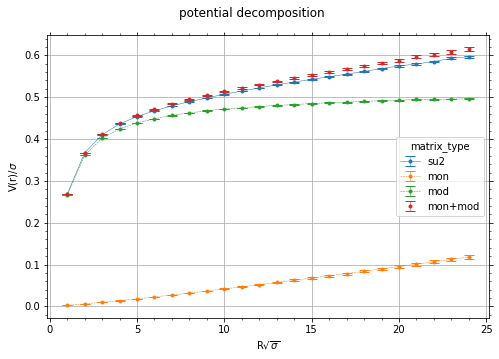

../../images/potential/decomposition/su2_suzuki/potential_su2_suzuki_beta2p8_0p0005


In [18]:
path = '../../result/smearing/potential/su2/su2_suzuki/48^4/beta2.8'
paths = {'su2': (f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/potential_original.csv', 400, 6), 
        'monopole': (f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/T_step=0.0005/T_final=0.0005/OR_steps=4/potential_monopole.csv', 300, 16), 
        'monopoless': (f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/T_step=0.0005/T_final=0.0005/OR_steps=4/potential_monopoless.csv', 300, 6)}
potential_decomposition(paths, f'../../images/potential/decomposition/su2_suzuki', 'potential_su2_suzuki_beta2p8_0p0005', 1)

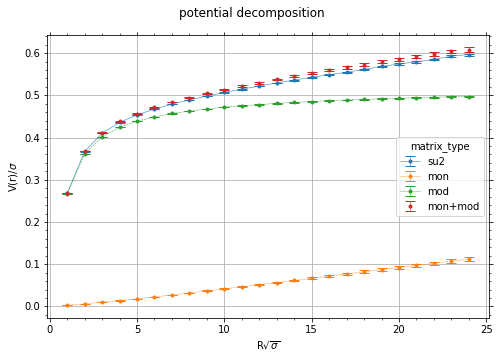

../../images/potential/decomposition/su2_suzuki/potential_su2_suzuki_beta2p8_0p0001


In [19]:
path = '../../result/smearing/potential/su2/su2_suzuki/48^4/beta2.8'
paths = {'su2': (f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/potential_original.csv', 400, 6), 
        'monopole': (f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/T_step=0.0001/T_final=0.5/OR_steps=4/potential_monopole.csv', 200, 16), 
        'monopoless': (f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/T_step=0.0001/T_final=0.5/OR_steps=4/potential_monopoless.csv', 300, 6)}
potential_decomposition(paths, f'../../images/potential/decomposition/su2_suzuki', 'potential_su2_suzuki_beta2p8_0p0001', 1)

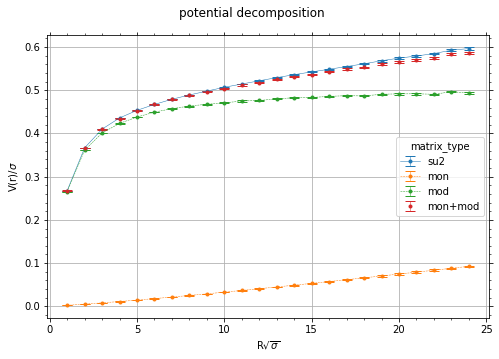

../../images/potential/decomposition/su2_suzuki/potential_su2_suzuki_beta2p8_5e-05


In [10]:
path = '../../result/smearing/potential/su2/su2_suzuki/48^4/beta2.8'
paths = {'su2': (f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/potential_original.csv', 400, 6), 
        'monopole': (f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/T_step=5e-05/T_final=0.5/OR_steps=4/potential_monopole.csv', 400, 6), 
        'monopoless': (f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/T_step=5e-05/T_final=0.5/OR_steps=4/potential_monopoless.csv', 400, 8)}
potential_decomposition(paths, f'../../images/potential/decomposition/su2_suzuki', 'potential_su2_suzuki_beta2p8_5e-05', 1)

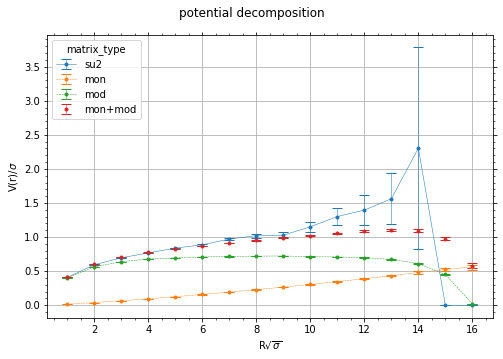

../../images/potential/decomposition/su3/gluodynamics/16^4/beta6.0/potential_decomposition_16^4_beta6p0


In [11]:
path = '../../result/smearing/potential/su3/gluodynamics/16^4/beta6.0'
paths = {'su2': (f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/potential_original.csv', 600, 5), 
        'monopole': (f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/compensate_1/potential_monopole.csv', 600, 5), 
        'monopoless': (f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/compensate_1/potential_monopoless.csv', 600, 5)}
potential_decomposition(paths, f'../../images/potential/decomposition/su3/gluodynamics/16^4/beta6.0', 'potential_decomposition_16^4_beta6p0', 1)

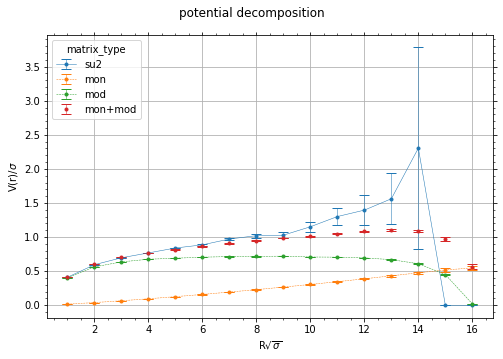

../../images/potential/decomposition/su3/gluodynamics/16^4/beta6.0/potential_decomposition_16^4_beta6p0


In [12]:
path = '../../result/smearing/potential/su3/gluodynamics/16^4/beta6.0'
paths = {'su2': (f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/potential_original.csv', 600, 5), 
        'monopole': (f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/compensate_0/potential_monopole.csv', 600, 5), 
        'monopoless': (f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/compensate_0/potential_monopoless.csv', 600, 5)}
potential_decomposition(paths, f'../../images/potential/decomposition/su3/gluodynamics/16^4/beta6.0', 'potential_decomposition_16^4_beta6p0', 1)

In [ ]:
path = '../../result/smearing/potential/su3/gluodynamics/16^4/beta6.0'
paths = {'su3': (f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/potential_original.csv', 500, 5), 
        'monopole': (f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/potential_monopole.csv', 500, 5), 
        'monopoless': (f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/potential_monopoless.csv', 500, 5)}
potential_decomposition(paths, f'../../images/potential/decomposition/su3/gluodynamics/16^4/beta6.0', 'potential_decomposition_16^4_beta6p0', 1)

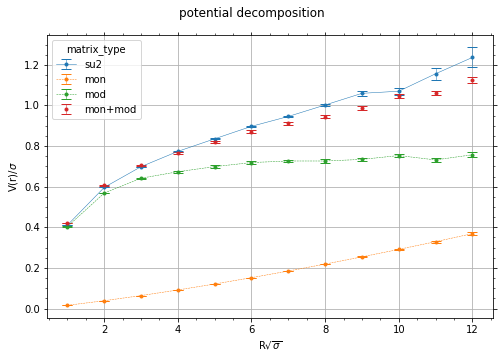

../../images/potential/decomposition/su3/gluodynamics/24^4/beta6.0/potential_decomposition_24^4_beta6p0


In [11]:
path = '../../result/smearing/potential/su3/gluodynamics/24^4/beta6.0'
paths = {'su2': (f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/potential_original.csv', 700, 6), 
        'monopole': (f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/DP_steps_500/copies=3/potential_monopole.csv', 600, 11), 
        'monopoless': (f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/DP_steps_500/copies=3/potential_monopoless.csv', 600, 8)}
potential_decomposition(paths, f'../../images/potential/decomposition/su3/gluodynamics/24^4/beta6.0', 'potential_decomposition_24^4_beta6p0', 1)

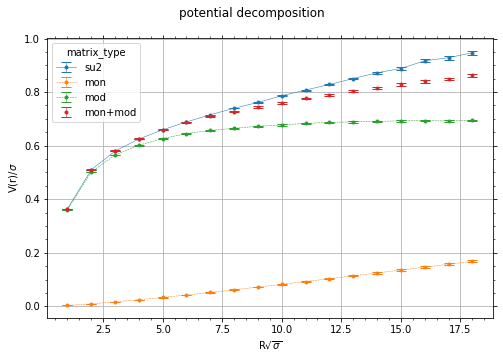

../../images/potential/decomposition/su3/gluodynamics/36^4/beta6.3/potential_decomposition_36^4_beta6p3


In [14]:
path = '../../result/smearing/potential/su3/gluodynamics/36^4/beta6.3'
paths = {'su2': (f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/potential_original.csv', 700, 7), 
        'monopole': (f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/DP_steps_500/copies=3/potential_monopole.csv', 600, 2), 
        'monopoless': (f'{path}/HYP0_alpha=1_1_0.5_APE_alpha=0.5/DP_steps_500/copies=3/potential_monopoless.csv', 600, 8)}
potential_decomposition(paths, f'../../images/potential/decomposition/su3/gluodynamics/36^4/beta6.3', 'potential_decomposition_36^4_beta6p3', 1)

In [ ]:
path = '../result/potential/on-axis/su2/qc2dstag/40^4/mu0.05/smeared'
potential_decomposition(path, {'su2': 10, 'monopole': 16, 'monopoless': 14}, f'../images/potential/decomposition/mu0.00/HYP0_alpha=1_1_0.5_APE200_alpha=0.5', 'potential_mu00', 0.0128912)

In [ ]:
path = '../result/potential/on-axis/su2/qc2dstag/40^4/mu0.20/smeared'
potential_decomposition(path, {'su2': 4, 'monopole': 10, 'monopoless': 8}, f'../images/potential/decomposition/qc2dstag', 'potential_qc2dstag_mu20', 0.0128912)

In [ ]:
path = '../result/potential/on-axis/su2/qc2dstag/40^4/mu0.25/smeared'
potential_decomposition(path, {'su2': 6, 'monopole': 10, 'monopoless': 6}, f'../images/potential/decomposition/mu0.00/HYP0_alpha=1_1_0.5_APE200_alpha=0.5', 'potential_mu00', 0.0128912)

In [ ]:
path = '../result/potential/on-axis/su2/qc2dstag/40^4/mu0.30/smeared'
potential_decomposition(path, {'su2': 4, 'monopole': 10, 'monopoless': 8}, f'../images/potential/decomposition/qc2dstag', 'potential_qc2dstag_mu30', 0.0128912)

In [ ]:
path = '../result/potential/on-axis/su2/qc2dstag/40^4/mu0.35/smeared'
potential_decomposition(path, {'su2': 8, 'monopole': 12, 'monopoless': 8}, f'../images/potential/decomposition/mu0.00', 'potential_mu00', 0.0128912)

In [ ]:
path = '../result/potential/on-axis/su2/qc2dstag/40^4/mu0.45/smeared'
potential_decomposition(path, {'su2': 8, 'monopole': 14, 'monopoless': 14}, f'../images/potential/decomposition/mu0.00', 'potential_mu00', 0.0128912)

In [ ]:
path = '../result/potential/on-axis/su2/su2_suzuki/48^4/beta2.7/HYP1_alpha=1_1_0.5_APE400_alpha=0.5'
potential_decomposition(path, {'su2': 10, 'monopole': 18, 'monopoless': 14}, f'../images/potential/decomposition/mu0.00', 'potential_mu00', 0.0128912)

In [ ]:
path = '../result/potential/on-axis/su2/su2_suzuki/24^4/beta2.4/HYP0_alpha=1_1_0.5_APE100_alpha=0.5'
potential_decomposition(path, {'su2': 4, 'monopole': 4, 'monopoless': 4}, f'../images/potential/decomposition/beta2.4', 'potential_beta2p4', 0.258265528440037)

In [ ]:
path = '../result/potential/on-axis/su2/su2_suzuki/24^4/beta2.5/HYP0_alpha=1_1_0.5_APE100_alpha=0.5'
potential_decomposition(path, {'su2': 4, 'monopole': 4, 'monopoless': 4}, f'../images/potential/decomposition/beta2.5', 'potential_beta2p5', 0.258265528440037)

In [ ]:
path = '../result/potential/on-axis/su2/su2_suzuki/24^4/beta2.6/HYP0_alpha=1_1_0.5_APE100_alpha=0.5'
potential_decomposition(path, {'su2': 4, 'monopole': 4, 'monopoless': 4}, f'../images/potential/decomposition/beta2.6', 'potential_beta2p6', 0.258265528440037)

In [ ]:
path = '../result/potential_adjoint/on-axis/su2/su2_suzuki/24^4/beta2.4/HYP0_alpha=1_0.5_0.5_APE100_alpha=0.5'
potential_decomposition(path, {'su2': 4, 'monopole': 4, 'monopoless': 4}, f'../images/potential_adjoint/decomposition/beta2.4', 'potential_adjoint_beta2p4', 0.258265528440037)

In [ ]:
path = '../result/potential_adjoint/on-axis/su2/su2_suzuki/24^4/beta2.5/HYP1_alpha=1_0.5_0.5_APE100_alpha=0.5'
potential_decomposition(path, {'su2': 4, 'monopole': 4, 'monopoless': 4}, f'../images/potential_adjoint/decomposition/beta2.5', 'potential_adjoint_beta2p5', 0.258265528440037)

In [ ]:
path = '../result/potential_adjoint/on-axis/su2/su2_suzuki/24^4/beta2.6/HYP0_alpha=1_0.5_0.5_APE100_alpha=0.5'
potential_decomposition(path, {'su2': 4, 'monopole': 4, 'monopoless': 4}, f'../images/potential_adjoint/decomposition/beta2.6', 'potential_adjoint_beta2p6', 0.258265528440037)

In [ ]:
path = '../result/potential_adjoint/on-axis/su2/qc2dstag/40^4/mu0.00/HYP1_alpha=1_1_0.5_APE200_alpha=0.5'
potential_decomposition(path, {'su2': 4, 'monopole': 6, 'monopoless': 6}, f'../images/potential_adjoint/decomposition/mu0.00', 'potential_mu00', 0.258265528440037)

In [ ]:
path = '../result/potential/on-axis/su2/su2_suzuki/24^4/beta2.4/HYP0_alpha=1_1_0.5_APE100_alpha=0.5'
potential_decomposition_phot(path, {'abelian': 4, 'monopole': 5, 'photon': 5}, f'../images/potential/decomposition_phot/beta2.4', 'potential_beta2p4', 0.258265528440037)

In [ ]:
path = '../result/potential/on-axis/su2/su2_suzuki/24^4/beta2.5/HYP0_alpha=1_1_0.5_APE100_alpha=0.5'
potential_decomposition_phot(path, {'abelian': 4, 'monopole': 5, 'photon': 4}, f'../images/potential/decomposition_phot/beta2.5', 'potential_beta2p5', 0.258265528440037)

In [ ]:
path = '../result/potential/on-axis/su2/su2_suzuki/24^4/beta2.6/HYP0_alpha=1_1_0.5_APE100_alpha=0.5'
potential_decomposition_phot(path, {'abelian': 5, 'monopole': 5, 'photon': 5}, f'../images/potential/decomposition_phot/beta2.6', 'potential_beta2p6', 0.258265528440037)

In [ ]:
path = '../result/potential/on-axis/su2/qc2dstag/40^4/mu0.00/HYP0_alpha=1_1_0.5_APE200_alpha=0.5'
potential_decomposition_phot(path, {'abelian': 4, 'monopole': 5, 'photon': 5}, f'../images/potential/decomposition_phot/mu0.00', 'potential_mu0.00', 0.258265528440037)

In [ ]:
relative_variation_potential()

In [ ]:
def plot_time_dependence(mu, monopole, lattice_size, smearing, statistics_type):
    df_data_40_5 = pd.read_csv(f"../result/potential/on-axis/{monopole}/qc2dstag/{smearing}/{lattice_size}/potential_mu=0.{mu}.csv", index_col=None)
    
    time_sizes = [6, 8, 10, 12, 14, 16, 18, 20]
#     space_sizes = [1, 2, 3]
    
    df1 = df_data_40_5[df_data_40_5['T'].isin(time_sizes)]
#     df1 = df1[df1['r/a'].isin(space_sizes)]
    fg = seaborn.FacetGrid(data=df1, hue='T',  aspect=1.61)
    fg.map(plt.errorbar, 'r/a', f'aV{statistics_type}(r)', f'err{statistics_type}', marker="o", fmt='', linestyle = '').add_legend()
    
    image_path = f'../images/potential/on-axis/qc2dstag/{smearing}/{lattice_size}'
    try:
        os.makedirs(image_path)
    except:
        pass
    
    image_path = f'{image_path}/potential_{monopole}_mu=0p{mu}_time_dependence'
    fg.savefig(image_path)
    
def plot_time_dependence_space(mu, monopole, smearing, lattice_size):
    df_data_40_5 = pd.read_csv(f"../result/potential_spatial/{monopole}/qc2dstag/{lattice_size}/potential_spatial_mu=0.{mu}.csv", index_col=None)
    
    time_sizes = [6, 8, 10, 12, 14, 16, 18, 20]
    
    df1 = df_data_40_5[df_data_40_5['T'].isin(time_sizes)]
    fg = seaborn.FacetGrid(data=df1, hue='T',  aspect=1.61)
    fg.map(plt.errorbar, 'r/a', 'aV(r)', 'err', marker="o", fmt='', linestyle = '').add_legend()
    
    image_path = f'../images/potential_spatial/qc2dstag/{lattice_size}'
    try:
        os.makedirs(image_path)
    except:
        pass
    
    image_path = f'{image_path}/potential_space_{monopole}_mu=0p{mu}_time_dependence'
    fg.savefig(image_path)

In [ ]:
plot_time_dependence('05', 'monopole', '40^4', 'smeared')
plot_time_dependence('35', 'monopole', '40^4')
plot_time_dependence('45', 'monopole', '40^4')

In [ ]:
plot_time_dependence('05', 'monopoless', '40^4')
plot_time_dependence('35', 'monopoless', '40^4')
plot_time_dependence('45', 'monopoless', '40^4')

In [ ]:
plot_time_dependence('05', '', '40^4', 'smeared')
plot_time_dependence('35', '', '40^4', 'smeared')
plot_time_dependence('45', '', '40^4', 'smeared')

In [ ]:
plot_time_dependence('05', '', '40^4', 'unsmeared')

In [ ]:
plot_time_dependence('00', 'monopole', '32^4', 'unsmeared')
plot_time_dependence('00', 'monopoless', '32^4', 'smeared')
plot_time_dependence('00', '', '32^4', 'smeared')

In [ ]:
plot_time_dependence('00', '', '32^4', 'HYP1_alpha=1_1_0.5_APE60_APE_alpha=0.75', '')
plot_time_dependence('00', '', '32^4', 'HYP1_alpha=1_1_0.5_APE60_APE_alpha=0.75', '1')
plot_time_dependence('00', '', '32^4', 'HYP1_alpha=1_1_0.5_APE60_APE_alpha=0.75', '2')

In [ ]:
plot_time_dependence_space('05', '', '', '40^4')

In [4]:
def plot_time_dependence_several_sizes(mu, monopole, lattice_size, smearing, space_sizes, statistics_type):
    df_data = pd.read_csv(f"../result/potential/on-axis/{monopole}/qc2dstag/{smearing}/{lattice_size}/potential_mu=0.{mu}.csv", index_col=None)
    
#     time_sizes = [6, 8, 10, 12, 14, 16, 18, 20]
#     space_sizes = [1, 2, 3]
    
    df1 = df_data[df_data['r/a'].isin(space_sizes)]
    df1 = df1[df1['T'] <= 16]
    fg = seaborn.FacetGrid(data=df1, hue='r/a',  aspect=1.61)
    fg.map(plt.errorbar, 'T', f'aV{statistics_type}(r)', f'err{statistics_type}', marker="o", fmt='', linestyle = '').add_legend()
    
    image_path = f'../images/potential/on-axis/qc2dstag/{smearing}/{lattice_size}'
    try:
        os.makedirs(image_path)
    except:
        pass
    
    image_path = f'{image_path}/potential_{monopole}_mu=0p{mu}_time_dependence'
    fg.savefig(image_path)

In [ ]:
space_sizes = [[1], [6], [10], [14], [18]]
for space_size in space_sizes:
    plot_time_dependence_several_sizes('05', '', '40^4', 'smeared', space_size, '')

In [ ]:
space_sizes = [[1], [2], [3], [4], [6], [10], [14], [16]]
for space_size in space_sizes:
    plot_time_dependence_several_sizes('00', '', '32^4', 'HYP1_alpha=1_1_0.5_APE60_APE_alpha=0.75', space_size, '')

In [ ]:
space_sizes = [[1], [2], [3], [4], [6], [10], [14], [16]]
for space_size in space_sizes:
    plot_time_dependence_several_sizes('00', '', '32^4', 'HYP1_alpha=1_1_0.5_APE60_APE_alpha=0.75', space_size, '1')

In [ ]:
space_sizes = [[1], [2], [3], [4], [6], [10], [14], [16]]
for space_size in space_sizes:
    plot_time_dependence_several_sizes('00', '', '32^4', 'HYP1_alpha=1_1_0.5_APE60_APE_alpha=0.75', space_size, '2')

In [5]:
from scipy.optimize import curve_fit

def make_potential_trunin(data, df1, df, time_size_max):
   
    time_size = data["T"].iloc[0]
    space_size = data["r/a"].iloc[0]

    if time_size < time_size_max:

        wilson_loop_T = df[(df['T'] == time_size) & (df['r/a'] == space_size)]['wilson_loop'].values[0]
        wilson_loop_T1 = df[(df['T'] == time_size + 1) & (df['r/a'] == space_size)]['wilson_loop'].values[0]

        wilson_loop_err_T = df[(df['T'] == time_size) & (df['r/a'] == space_size)]['wilson_loop_err'].values[0]
        wilson_loop_err_T1 = df[(df['T'] == time_size + 1) & (df['r/a'] == space_size)]['wilson_loop_err'].values[0]

        try:
            new_row = {'aV(r)': math.log(wilson_loop_T/wilson_loop_T1), 'err': math.sqrt(wilson_loop_err_T ** 2 / wilson_loop_T1 ** 2 + wilson_loop_err_T1 ** 2 * wilson_loop_T ** 2 / wilson_loop_T1 ** 4)}

            df1 = df1.append(new_row, ignore_index=True)

            return df1
        except ValueError:
            return df1

def plots_T(data, fit_start, fit_end, procedure, T_lim):

    x = data[(data['T'] >= fit_start) & (data['T'] <= fit_end)]['T'].to_numpy()
    y = data[(data['T'] >= fit_start) & (data['T'] <= fit_end)]['aV(r)'].to_numpy()

    fg = seaborn.FacetGrid(data=data, height=5, aspect=1.2)
    fg.map(plt.errorbar, 'T', 'aV(r)', 'err', marker="o", fmt='', linestyle = '')

    if procedure == 'fitting':
        popt, pcov = curve_fit(func_exponent, x, y)

        x1 = np.arange(x.min(), x.max(), 0.01)
        y1 = func_exponent(x1, popt[0], popt[1], popt[2])

        plt.plot(x1, y1)

    plt.show()

    if procedure == 'fitting':
        return pd.Series([popt[0], math.sqrt(pcov[0][0])], index=['aV(r)', 'err'])
    elif procedure == 'limit':
        return pd.Series([data[data['T'] == T_lim]['aV(r)'].iloc[0], data[data['T'] == T_lim]['err'].iloc[0]], index=['aV(r)', 'err'])


def func_exponent(x, a, b, c):
    return a + b * np.exp(-x * c)

def func_linear_potential(x, c, alpha, sigma):
    return c + alpha * np.power(x, -1) + sigma * x

def func_coulomb(x, c, alpha, mu):
    return c + alpha * np.exp(-mu * x) * np.power(x, -1)
    

In [96]:
def get_string_tension(path, fit_start, fit_end, procedure):    

    data = pd.read_csv(path, header=0, names=['r/a', "T", "wilson_loop", "wilson_loop_err"], delim_whitespace=True)

    time_size_max = data["T"].max()

    df1 = pd.DataFrame(columns=["aV(r)", "err"])

    df1 = data.groupby(['T', 'r/a']).apply(make_potential_trunin, df1, data, time_size_max).reset_index()

    print("fitting")

    df = df1.groupby(['r/a']).apply(plots_T, 2, 10, procedure, 10).reset_index()

    x = df[(df['r/a'] >= fit_start) & (df['r/a'] <= fit_end)]['r/a'].to_numpy()
    y = df[(df['r/a'] >= fit_start) & (df['r/a'] <= fit_end)]['aV(r)'].to_numpy()

    popt, pcov = curve_fit(func_linear_potential, x, y) 

    print(popt[0], popt[1], popt[2])

    fg = seaborn.FacetGrid(data=df, height=5, aspect=1.2)
    fg.map(plt.errorbar, 'r/a', 'aV(r)', 'err', marker="o", fmt='', linestyle = '')

    x1 = np.arange(x.min(), x.max(), 0.01)
    y1 = func_linear_potential(x1, popt[0], popt[1], popt[2])

    plt.plot(x1, y1)

    plt.show()

    return popt[2], math.sqrt(pcov[2][2])

def get_string_tension_test(path, fit_start, fit_end):

    df_common = []

    data = pd.read_csv(path, header=0, names=['r/a', "T", "wilson_loop", "wilson_loop_err"], delim_whitespace=True)

    time_size_max = data["T"].max()

    df1 = pd.DataFrame(columns=["aV(r)", "err"])

    df1 = data.groupby(['T', 'r/a']).apply(make_potential_trunin, df1, data, time_size_max).reset_index()

    df = df1.groupby(['r/a']).apply(plots_T, 2, 10, 'fitting', 8).reset_index()

    df_common.append(df)
    df_common[-1]['procedure'] = 'fitting'

    x = df[(df['r/a'] >= fit_start) & (df['r/a'] <= fit_end)]['r/a'].to_numpy()
    y = df[(df['r/a'] >= fit_start) & (df['r/a'] <= fit_end)]['aV(r)'].to_numpy()

    popt, pcov = curve_fit(func_linear_potential, x, y) 

    print(popt[0], popt[1], popt[2])

    # fg = seaborn.FacetGrid(data=df, height=5, aspect=1.2)
    # fg.map(plt.errorbar, 'r/a', 'aV(r)', 'err', marker="o", fmt='', linestyle = '')

    x1 = np.arange(x.min(), x.max(), 0.01)
    y1 = func_linear_potential(x1, popt[0], popt[1], popt[2])

    df = df1.groupby(['r/a']).apply(plots_T, 2, 10, 'limit', 8).reset_index()

    df_common.append(df)
    df_common[-1]['procedure'] = 'limit'

    df_common = pd.concat(df_common)

    x = df[(df['r/a'] >= fit_start) & (df['r/a'] <= fit_end)]['r/a'].to_numpy()
    y = df[(df['r/a'] >= fit_start) & (df['r/a'] <= fit_end)]['aV(r)'].to_numpy()

    popt, pcov = curve_fit(func_linear_potential, x, y) 

    print(popt[0], popt[1], popt[2])

    fg = seaborn.FacetGrid(data=df_common, hue = 'procedure', height=5, aspect=1.2)
    fg.map(plt.errorbar, 'r/a', 'aV(r)', 'err', marker="o", fmt='', linestyle = '').add_legend()

    x2 = np.arange(x.min(), x.max(), 0.01)
    y2 = func_linear_potential(x1, popt[0], popt[1], popt[2])

    # plt.plot(x1, y1)

    # plt.plot(x2, y2)

    plt.show()

fitting


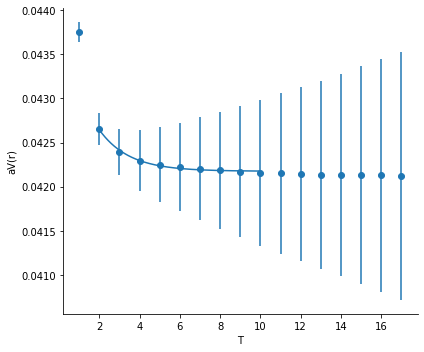

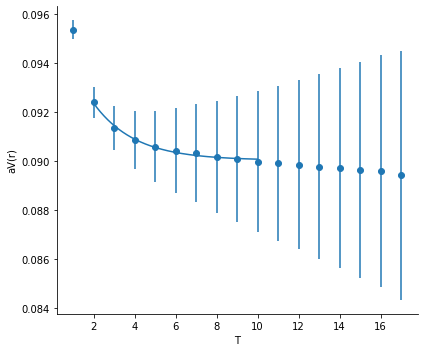

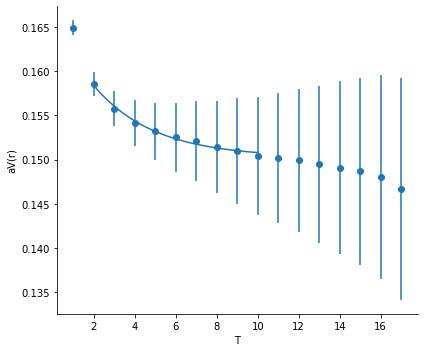

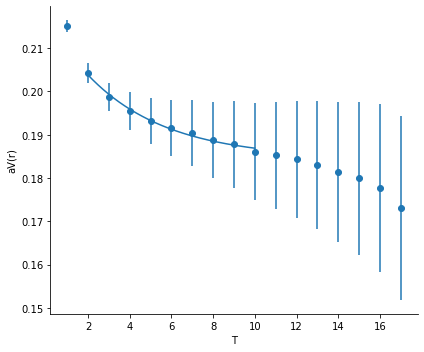

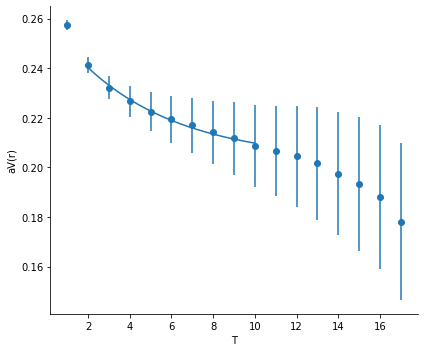

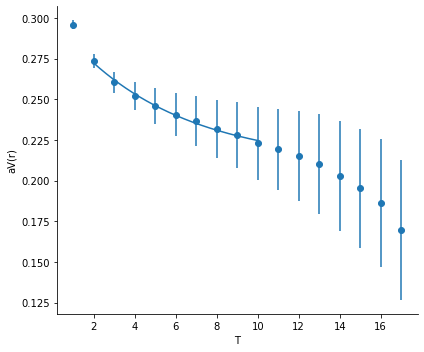

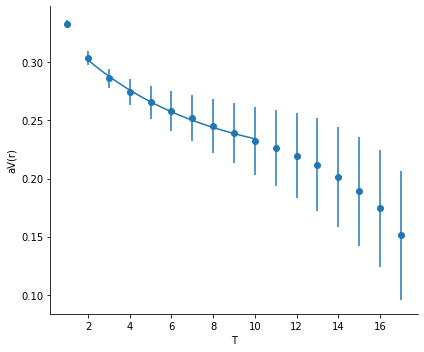

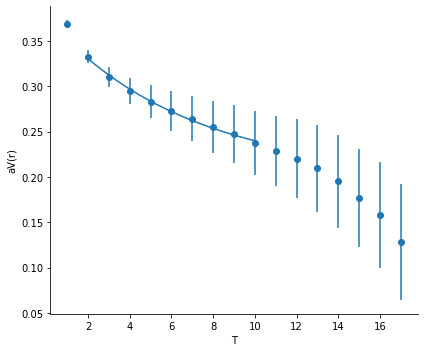

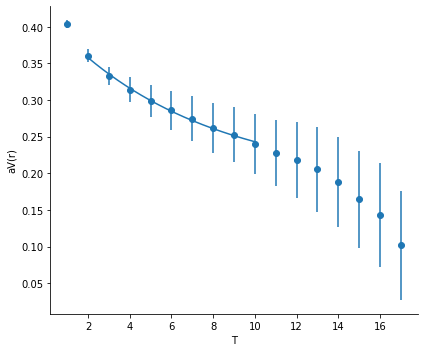

/home/ilya/.local/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


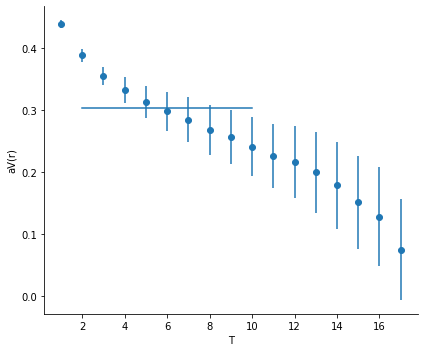

0.21154729529504324 -0.2523391681872307 0.0059686707426861866


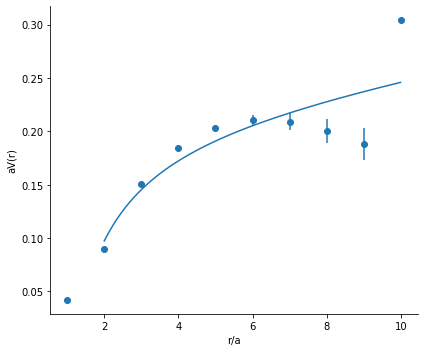

(0.0059686707426861866, 0.010099616490027058)

In [104]:
get_string_tension(f"../result/potential/on-axis/su2/trunin/Wr_mu=0.25_nt=20", 2, 10, 'fitting')

In [98]:
def string_tension_dependence(nt):
    arr_mu = ['0.0', '0.25', '0.35', '0.45']
    string_tension = []
    string_tension_err = []

    for mu in arr_mu:
        sigma, err = get_string_tension(f"../result/potential/on-axis/su2/trunin/Wr_mu={mu}_nt={nt}", 2, 10, 'limit')
        string_tension.append(sigma)
        string_tension_err.append(err)

    print(string_tension)
    plt.errorbar(list(map(float, arr_mu)), string_tension)

In [ ]:
string_tension_dependence(20)

In [ ]:
string_tension_dependence(24)

In [ ]:
string_tension_dependence(28)

In [ ]:
string_tension_dependence(32)

In [ ]:
string_tension_dependence(36)

In [ ]:
string_tension_dependence(40)

In [ ]:
get_string_tension_test(f"../result/potential/on-axis/su2/trunin/Wr_mu=0.0_nt=20", 2, 10)
get_string_tension_test(f"../result/potential/on-axis/su2/trunin/Wr_mu=0.25_nt=20", 2, 10)
get_string_tension_test(f"../result/potential/on-axis/su2/trunin/Wr_mu=0.35_nt=20", 2, 10)
get_string_tension_test(f"../result/potential/on-axis/su2/trunin/Wr_mu=0.45_nt=20", 2, 10)